In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.applications import imagenet_utils
from keras.preprocessing.image import *
from keras.utils import multi_gpu_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *

import multiprocessing
from multiprocessing.dummy import Pool
from pprint import pprint

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6,7'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

Using TensorFlow backend.


In [2]:
batch_size = 4 * n_gpus
model_name = ''
preprocess_func = inception_resnet_v2.preprocess_input
MODEL = InceptionResNetV2

f = 2
width = int(2560 / f)
height = int(1920 / f)
classes = ['正常', '吊经', '擦洞', '跳花', '毛洞', '织稀', '扎洞', '缺经', '毛斑', '其他']
n_classes = len(classes)

In [3]:
idg = ImageDataGenerator()
gen_test = idg.flow_from_directory('test', target_size=(height, width), shuffle=False, 
                                    class_mode=None, batch_size=batch_size)

Found 662 images belonging to 1 classes.


# 按 val_auc 排序

In [4]:
a = [(x[x.rfind('-')+1:x.rfind('.')], x) for x in glob('models/*.h5')]
a = sorted(a, key=lambda x:x[0], reverse=True)[:50]
a

[('0.962335', 'models/irv2_0731-0.001001-120-0.962335.h5'),
 ('0.954225', 'models/irv2_0801-0.000100-60-0.954225.h5')]

# 构建模型

In [5]:
base_model = MODEL(include_top=False, weights='imagenet')
input_tensor = Input((height, width, 3))
x = Lambda(preprocess_func)(input_tensor)
x = base_model(x)
x = GlobalAvgPool2D()(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_tensor, x)

In [6]:
model_parallel = multi_gpu_model(model, n_gpus)

# 预测结果

In [7]:
def predict(fname_model):
    model.load_weights(fname_model)
    y_pred = model_parallel.predict_generator(gen_test, verbose=1, workers=multiprocessing.cpu_count())
    
    y_pred2 = 1 - y_pred[:,0]
    y_pred2 = np.round(y_pred2, 6).clip(1e-6, 1-1e-6)
    
    plt.figure()
    plt.hist(y_pred2);
    
    fname_model2 = fname_model[fname_model.rfind('/')+1:]
    with open(f'outs/pred_{fname_model2}.csv', 'w') as f:
        f.write('filename,probability\n')
        for fname, value in zip(gen_test.filenames, y_pred2):
            fname = fname[fname.rfind('/')+1:]
            f.write(f'{fname},{value:.6f}\n')

models/irv2_0731-0.001001-120-0.962335.h5
42/42 [==============================] - 60s 1s/step
models/irv2_0801-0.000100-60-0.954225.h5
42/42 [==============================] - 38s 904ms/step


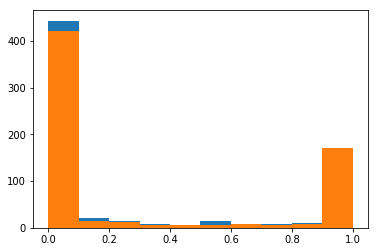

In [8]:
for _, fname_model in a:
    print(fname_model)
    predict(fname_model)

# 探索

In [16]:
# y_preds = []
# fnames_model = sorted(glob("models/irv2_0801*"), key=lambda x:int(x.split('-')[2]))
# for i, fname_model in enumerate(fnames_model[-10:]):
#     model.load_weights(fname_model)
#     y_pred = model_parallel.predict_generator(gen_test, verbose=1, workers=multiprocessing.cpu_count())
#     y_preds.append(y_pred)
#     print(i, (y_pred[:,0] < 0.5).sum())

0 192
1 182
2 189
3 170
4 188
5 189
6 169
7 180
8 178
9 179
